In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from IPython.core.display import clear_output, display
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df, get_pd_line_graph, \
    apply_nodes_restrictions, apply_edge_restriction, construct_output_graph
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical


import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from prepare import parse

csv_params = {
"sep": '\s+',
#"nrows": 15000,
"encoding": 'utf-8',
"names": ['event',  'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0']
}
suff_df = ('_p', '_c')
gin.bind_parameter('get_pd_line_graph.restrictions_0',(-0.2, 0.2))
gin.bind_parameter('get_pd_line_graph.restrictions_1', (-0.28, 0.28))
gin.bind_parameter('get_pd_line_graph.suffix_c', '_c')
gin.bind_parameter('get_pd_line_graph.suffix_p','_p')
gin.bind_parameter('get_supernodes_df.suffix_c', '_c')
gin.bind_parameter('get_supernodes_df.suffix_p', '_p')
gin.bind_parameter('get_supernodes_df.axes', ['r', 'phi', 'z'])
gin.bind_parameter('apply_edge_restriction.edge_restriction', 0.093)
stations_constraints = {
    0: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    1: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    2: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
}

In [3]:
events = parse("/zfs/hybrilit.jinr.ru/user/p/pgonchar/data/bes3/events/3.txt", csv_params=csv_params, events_quantity='0..20000')
events = next(events)[0]
n_events = 20000
events_to_analyze = events[events.event < n_events]

In [4]:
from collections import namedtuple
GraphWithIndices = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y', 'v', 'v_from_to','e_from_to', 'ev_id' ])

def construct_graph_with_indices(graph, v_inds, v_from_to, e_from_to, ev_id):
    return GraphWithIndices(graph.X, graph.Ri, graph.Ro, graph.y, v_inds, v_from_to, e_from_to, ev_id)

In [5]:
nodes = pd.DataFrame()
edges = pd.DataFrame()

graphs = {}

for idx, event in events_to_analyze.groupby('event'):
    clear_output(wait=True)
    display("Event #%09d" % idx)
    
    transformer = Compose([
            ConstraintsNormalize(
                use_global_constraints=False,
                constraints=stations_constraints
            ),
            ToCylindrical(drop_old=True, cart_columns=('y', 'x'))
        ])
    try:
        event = transformer(event)
    except AssertionError as err:
        print("ASS error %r" % err)
        continue
    G = to_pandas_graph_from_df(event, suffixes=suff_df, compute_is_true_track=True)
    nodes_t, edges_t = get_pd_line_graph(G, apply_nodes_restrictions)
    edges_filtered = apply_edge_restriction(edges_t)
    graph = construct_output_graph(nodes_t, edges_filtered, ['y_p', 'y_c', 'z_p', 'z_c', 'z'],
                                     [np.pi, np.pi, 1., 1., 1.], 'edge_index_p', 'edge_index_c')
    ev_id = event.event.values[0]
    graph_with_inds = construct_graph_with_indices(graph, 
                                                   nodes_t.index.values, 
                                                   nodes_t[['from_ind','to_ind']].values,
                                                   edges_filtered[['edge_index_p','edge_index_c']].values,
                                                   ev_id)
    np.testing.assert_allclose(graph_with_inds.X, 
                               nodes_t[['y_p', 'y_c', 'z_p', 'z_c', 'z']].values/[np.pi, np.pi, 1., 1., 1.])
    assert ev_id not in graphs
    graphs[ev_id] = graph_with_inds
    
    

'Event #000019999'

In [6]:
from ariadne.graph_net.model import GraphNet_v1
import torch

gin.bind_parameter('GraphNet_v1.input_dim', 5)
gin.bind_parameter('GraphNet_v1.hidden_dim', 128)
gin.bind_parameter('GraphNet_v1.n_iters', 1)

def weights_update(model, checkpoint):
    model_dict = model.state_dict()    
    pretrained_dict =  checkpoint['state_dict']
    real_dict = {}
    for (k,v) in model_dict.items():
        needed_key = None
        for pretr_key in pretrained_dict:
            if k in pretr_key:
                needed_key = pretr_key
                break
        assert needed_key is not None, "key %s not in pretrained_dict %r!" % (k, pretrained_dict.keys())
        real_dict[k] = pretrained_dict[needed_key]

    model.load_state_dict(real_dict)
    model.eval()
    return model

path = '/zfs/hybrilit.jinr.ru/user/g/gooldan/bes/ariadne/lightning_logs/version_63115/checkpoints/epoch=49.ckpt'
checkpoint = torch.load(path) if torch.cuda.is_available() else torch.load(path, map_location=torch.device('cpu'))
model = weights_update(model=GraphNet_v1(), 
                       checkpoint=checkpoint)


In [7]:
from ariadne.graph_net.dataset import GraphDatasetFromMemory, collate_fn
from ariadne.graph_net.data_loader import GraphDataLoader

graphs_list = list(graphs.values())

gin.bind_parameter('GraphDatasetFromMemory.input_graphs', graphs_list)

data_loader = GraphDataLoader(
    batch_size=1,
    dataset=GraphDatasetFromMemory,
    collate_fn=collate_fn,
    n_train=0,
    n_valid=len(graphs_list)-1    
).get_val_dataloader()

In [8]:
with torch.no_grad():
    test_outputs = [(model(batch_input).flatten(), batch_target.flatten())
                    for (batch_input, batch_target) in data_loader]
    test_pred, test_target = zip(*test_outputs)
    test_pred = np.concatenate(test_pred)
    test_target = np.concatenate(test_target)


In [9]:
import sklearn.metrics
thresh = 0.5
y_pred, y_true = (test_pred > thresh), (test_target > thresh)
print('Test set results with threshold of', thresh)
print('Accuracy:  %.6f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.6f' % sklearn.metrics.precision_score(y_true, y_pred))
print('Recall:    %.6f' % sklearn.metrics.recall_score(y_true, y_pred))

Test set results with threshold of 0.5
Accuracy:  0.977919
Precision: 0.901272
Recall:    0.960653


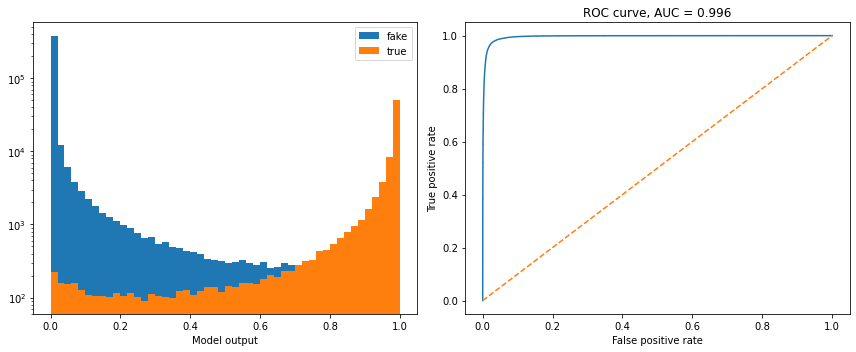

In [10]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the model outputs
binning=dict(bins=50, range=(0,1), histtype='bar', log=True)
ax0.hist(test_pred[y_true==False], label='fake', **binning)
ax0.hist(test_pred[y_true], label='true', **binning)
ax0.set_xlabel('Model output')
ax0.legend(loc=0)

# Plot the ROC curve
auc = sklearn.metrics.auc(fpr, tpr)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve, AUC = %.3f' % auc)

plt.tight_layout()

In [146]:
from itertools import chain
import datetime

total_events = 0

total_tracks = 0
total_tracks_true = 0
total_events_true = 0
total_hits = 0
total_hits_true = 0

all_tracks_df = pd.DataFrame(columns=['event', 'track', 'hit_0_id', 'hit_1_id', 'hit_2_id', 'px', 'py', 'pz', 'pred'])

all_events_df = pd.DataFrame(columns=['event','multiplicity','pred', 'time'])

for idx, event in events_to_analyze.groupby('event'):
    ev_id_real = event.event.values[0]
    clear_output(wait=True)
    display("Event #%09d" % idx)
    hits_in_event = set()
    
    tracks_in_event = event[event.track != -1].track.nunique()

    for tr_id, track in event.groupby('track'):
        if tr_id != -1:
            hits_in_event.update(track.index.values)
            
            all_tracks_df = all_tracks_df.append({
                'event':int(ev_id_real),
                'track':int(tr_id),
                'hit_0_id':int(track.index.values[0]),
                'hit_1_id':int(track.index.values[1] if len(track.index.values) > 1 else -1),
                'hit_2_id':int(track.index.values[2] if len(track.index.values) > 2 else -1),
                'px':track.px.values[0],
                'py':track.py.values[0],
                'pz':track.pz.values[0],
                'pred':int(0),
                'multiplicity':int(tracks_in_event)
            }, ignore_index=True)
    #total_hits_inds.extend(hits_in_event)
    total_tracks += tracks_in_event
    total_hits += len(hits_in_event)
    total_events += 1
    if ev_id_real not in graphs:
        continue
    graphed_event = event[['event', 'x', 'y','z','track', 'station']]
    time_start = datetime.datetime.now()
    G = to_pandas_graph_from_df(graphed_event, suffixes=suff_df, compute_is_true_track=True)

    tgt_graph = graphs[ev_id_real]
    batch_input, batch_target = collate_fn([tgt_graph])
    with torch.no_grad():
        y_pred = model(batch_input).numpy().flatten() > 0.5

    time_end = datetime.datetime.now()
    time_diff = (time_end - time_start).microseconds
    
    
    superedge_pred = tgt_graph.e_from_to[y_pred]
    edges_pred = [G.loc[pred]
                  for pred in superedge_pred]
    reco_tracks=0
    edge_ind_pred = [(edgs.iloc[0].index_old_p, 
                      edgs.iloc[0].index_old_c, 
                      edgs.iloc[1].index_old_c) for edgs in edges_pred]
    for track_cand in edge_ind_pred:
        atdv = all_tracks_df
        match = ((atdv.hit_0_id == track_cand[0]) & 
                 (atdv.hit_1_id == track_cand[1]) & 
                 (atdv.hit_2_id == track_cand[2]))
        
        matched_track = all_tracks_df[match]
        assert len(matched_track) < 2
        if matched_track.empty:
            all_tracks_df = all_tracks_df.append({
                'event':int(ev_id_real),
                'track':-1,
                'hit_0_id':int(track_cand[0]),
                'hit_1_id':int(track_cand[1]),
                'hit_2_id':int(track_cand[2]),
                'px':np.inf,
                'py':np.inf,
                'pz':np.inf,
                'pred':-1,                
                'multiplicity':int(tracks_in_event)
            }, ignore_index=True)
        else:            
            all_tracks_df.loc[match, 'pred'] = 1 
            total_tracks_true += 1
            reco_tracks += 1

    hits_pred = set(chain.from_iterable(edge_ind_pred))
    
    found_hits = hits_pred.intersection(hits_in_event)
    total_hits_true += len(found_hits)
    
    preddd=0

    if reco_tracks == tracks_in_event:
        total_events_true += 1
        preddd=1

    all_events_df = all_events_df.append({
        'event':int(ev_id_real),
        'multiplicity':int(tracks_in_event),
        'pred':preddd,
        'time':time_diff
    }, ignore_index=True)
        

all_tracks_df = all_tracks_df.astype({
    'event': 'int32',
    'track': 'int32',
    'hit_0_id': 'int32',
    'hit_1_id': 'int32',
    'hit_2_id': 'int32',
    'px': 'float32',
    'py': 'float32',    
    'pz': 'float32',
    'pred':'int32',
    'multiplicity':'int32'
})

all_events_df = all_events_df.astype({
    'event': 'int32',
    'pred':'int32',
    'multiplicity':'int32',
    'time':'int32'
})

'Event #000019999'

In [145]:
print("Total track efficiency: %.04f" % (total_tracks_true / total_tracks))
print("Total hit efficiency: %.04f" % (total_hits_true / total_hits))
print("Total event efficiency: %.04f" % (total_events_true / total_events))
print("Mean event processing speed: %.02f" % (all_events_df.time.mean()))

Total track efficiency: 0.8998
Total hit efficiency: 0.9326
Total event efficiency: 0.7159
Mean event processing speed: 14059.43


In [103]:
all_events_df.pred.unique()

array([1, 0], dtype=int32)

In [59]:
# shortcut
from numpy import linalg as LA

all_tracks_df['pt'] = LA.norm(all_tracks_df[['px','py']].values, axis=1)
all_tracks_df['cos_t'] = (all_tracks_df[['pz']].values/ LA.norm(all_tracks_df[['px','py','pz']].values, axis=1, keepdims=True))
all_tracks_df['a_phi'] = np.arctan2(all_tracks_df[['px']].values, all_tracks_df[['py']].values)

In [160]:
def get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col):
    spac = np.linspace(start, end, num=num)
    step = (spac[1] - spac[0]) / 2
    arr = []
    spac_ret = []
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] >= beg) & (all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] >= beg) & (found_hits[col] < end)]
        #print(beg,end)
        #print(len(elems_pred), len(elems_real))
        if elems_real.empty:
        #    print("emp", beg, end)
            continue
        arr.append(len(elems_pred) / len(elems_real))
        spac_ret.append(spac[i] + step)
    
    return np.array(arr), np.array(spac_ret)

from scipy import stats

def get_diagram_for_boxplot(all_real_hits, found_hits, start, end, num, col, bin_array, int_mode):
    y_vals, x_vals = get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col)

    np_y_vals = np.array(y_vals)
    bin_array = bin_array

    
    res_x_array = []
    res_box_data = []
    mean_box_array = []
    
    for i in range(len(bin_array)-1):
        beg = bin_array[i]
        end = bin_array[i+1]
        y_ind = np.where((x_vals>=beg) & (x_vals<end))
        y_vals_corr  = np_y_vals[y_ind]
        y_vals_corr = y_vals_corr[~np.isnan(y_vals_corr)]
        if len(y_vals_corr) == 0:
             continue
                
        #print(beg, end, i, stats.describe(y_vals_corr))
        #print(y_vals_corr)
#         if len(np.where(y_vals_corr < 1)) > 0:
#             print(y_vals_corr)
#             print(y_vals)
#             print(beg,end)
        
        res_box_data.append(y_vals_corr)
        delta = 0 if int_mode else (end-beg)/2
        res_x_array.append(beg + delta)
        mean_box_array.append(np.mean(y_vals_corr))

    return res_box_data, np.array(res_x_array), np.array(mean_box_array)
    #plt.boxplot(res_box_data, positions=bin_array)

In [178]:
from scipy.interpolate import make_interp_spline, BSpline

def boxplot_style(bp):
    for box in bp['boxes']:
            # change outline color
        #box.set( color='#7570b3', linewidth=2)
            # change fill color
        box.set( facecolor = 'silver' )
    
    ## change color and linewidth of the whiskers
    #for whisker in bp['whiskers']:
    #    whisker.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the caps
    #for cap in bp['caps']:
    #    cap.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='tab:cyan', linewidth=3, alpha=0)

    for median in bp['means']:
        median.set(color='tab:green', linewidth=4, ls='-', zorder=5)
    #
    ### change the style of fliers and their fill
    #for flier in bp['fliers']:
    #    flier.set(marker='o', color='#e7298a', alpha=0.5)

def draw_for_col(tracks_real, tracks_pred_true,
                 col, col_pretty, total_events, n_ticks=150, 
                 n_avg_ticks=-1, x_ticks=8,
                 custom_title=None,
                 ticks_custom=True,
                 with_boxplot=False,
                 int_mode=False, save_disk=True,
                 custom_draw_funcs=[],
                 diagram_func=None,
                 color_ax_ticks=False
                ):
    color_ax_ticks = len(custom_draw_funcs) > 0 and color_ax_ticks
    n_avg_ticks = n_ticks // 5 if n_avg_ticks < 0 else n_avg_ticks
    
    delta = 1e-4 if not int_mode else 1
    
    start = tracks_real[tracks_real[col] > -np.inf][col].min()
    end = tracks_real[tracks_real[col] < np.inf][col].max()+delta

    initial, spac = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, n_ticks, col)
    
    maxX = int(end) if int_mode else end
    plt.figure(figsize=(8,7))
    
    ax = plt.subplot(111)
    #plt.ylabel('Track efficiency', fontsize=12)
    plt.xlabel(col_pretty, fontsize=12)
    #plt.axis([0, maxX, 0, 1.005])
    plt.plot(spac, initial, alpha=0.0, lw=1)
    title = custom_title if custom_title else 'GraphNet_V1 track efficiency vs %s (%d events)' % (col_pretty, total_events)
    plt.title(title, fontsize=14)
    if not int_mode and ticks_custom:
        plt.xticks(np.linspace(start, maxX, x_ticks))
    else:
        plt.locator_params(axis='x', nbins=x_ticks)

    if diagram_func is None:
        plt.yticks(np.round(np.linspace(0, 1, 11), decimals=2))
    x_ticks = ax.get_xticks()
    if with_boxplot:
        old_ticks = x_ticks
        delta_x = (x_ticks[1] - x_ticks[0])/2
        diagram_func = get_diagram_for_boxplot if diagram_func is None else diagram_func
        
        box_data, ticks_x, mean_data = diagram_func(tracks_real, tracks_pred_true, start, end, 
                                                               n_ticks, col, x_ticks, int_mode)
        bp = plt.boxplot(box_data, positions=ticks_x, 
                    manage_ticks=False, meanline=True, showmeans=True,
                    widths=delta_x,patch_artist=True, sym='',zorder=3)
        boxplot_style(bp)

        # mean line
        xnew = np.linspace(ticks_x.min(), ticks_x.max(), 500) 

        spl = make_interp_spline(ticks_x, mean_data, k=3)  # type: BSpline
        power_smooth = spl(xnew)
        plt.plot(xnew, power_smooth, ls='--', color='tab:orange', label='mean efficiency', lw=3, zorder=4)
        plt.xticks(old_ticks)

    if diagram_func is None:
        ax.set_ylim((-0.05, 1.05))
    for draw_f in custom_draw_funcs:
        draw_f(ax)
    #plt.locator_params(axis='y', nbins=16)
    ax.legend(loc=0) 
    if color_ax_ticks:
        ax.tick_params(axis='y', labelcolor='tab:green')
    ax.grid()
    plt.tight_layout()
    plt.rcParams['savefig.facecolor']='white'
    os.makedirs('../output', exist_ok=True)
    plt.savefig('../output/new_img_track_eff_%s_ev%r_t%d.png'%(col, total_events, n_ticks), dpi=300)
    plt.show()

#from scipy.interpolate import make_interp_spline, BSpline
#second, spac2 = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, 25, 'pt')
#
#xnew = np.linspace(spac2.min(), spac2.max(), 30) 
#
#spl = make_interp_spline(spac2, second, k=3)  # type: BSpline
#power_smooth = spl(xnew)

In [62]:
tracks_real = all_tracks_df[all_tracks_df.pred != -1]
tracks_pred_true = all_tracks_df[all_tracks_df.pred == 1]


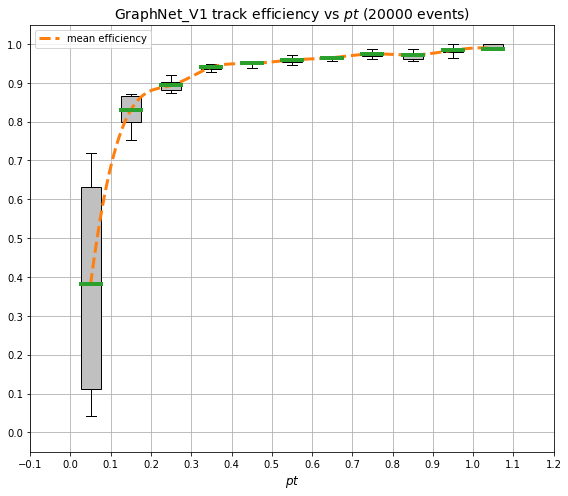

In [162]:
draw_for_col(tracks_real, tracks_pred_true, 'pt', '$pt$', 20000, 80, 
             n_avg_ticks=48, x_ticks=14, ticks_custom=False, with_boxplot=True)

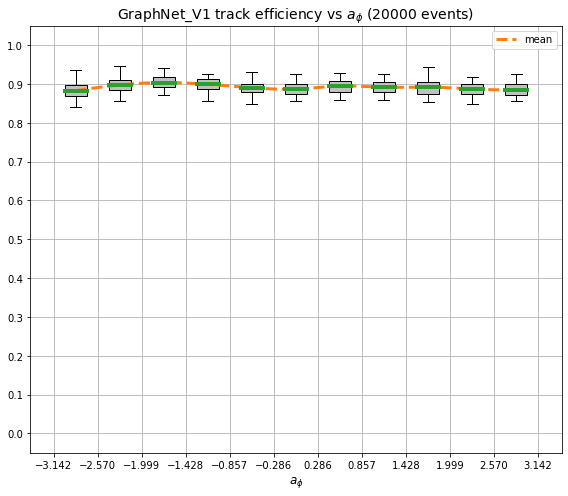

In [64]:
draw_for_col(tracks_real, tracks_pred_true, 'a_phi', '$a_\phi$',20000, 350, n_avg_ticks=60, x_ticks=12, with_boxplot=True)

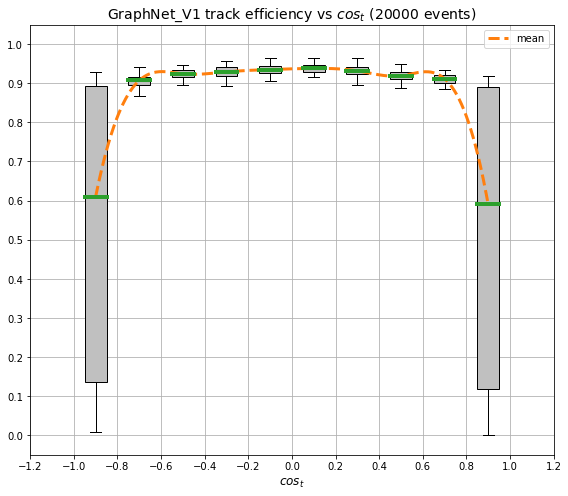

In [65]:
draw_for_col(tracks_real, tracks_pred_true, 'cos_t', '$cos_t$',20000, 350, n_avg_ticks=60,x_ticks=12, ticks_custom=False, with_boxplot=True)

In [148]:
events_real = all_events_df[all_events_df.pred != -1]
events_pred_true = all_events_df[all_events_df.pred == 1]


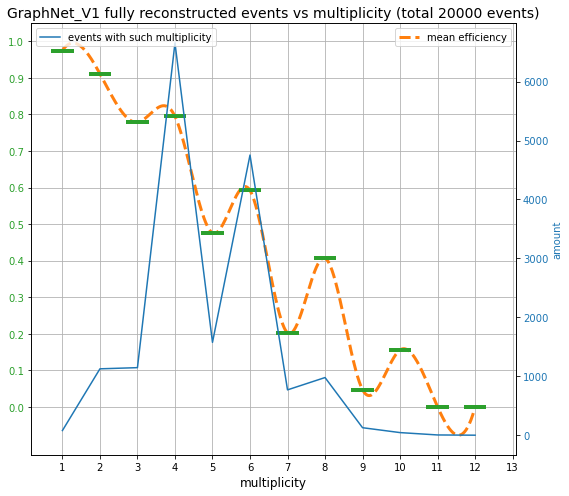

In [181]:
def get_diagram_arr_linspaceer(all_real_hits, found_hits, start, end, num, col):
    spac = np.linspace(start, end, num=num)
    step = (spac[1] - spac[0]) / 2
    arr = []
    spac_ret = []
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] >= beg) & (all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] >= beg) & (found_hits[col] < end)]
        #print(beg,end)
        #print(len(elems_pred), len(elems_real))
        if elems_real.empty:
        #    print("emp", beg, end)
            continue
        arr.append(len(elems_real))
        spac_ret.append(spac[i] + step)
    
    return np.array(arr), np.array(spac_ret)

def custom_draw_dist(ax):
    res_y, res_x = get_diagram_arr_linspaceer(events_real, events_real, 1, 13, 13, 'multiplicity')
    res_x = res_x - 0.5
    res_y = res_y

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('amount', color=color)  # we already handled the x-label with ax1
    ax2.plot(res_x, res_y, color=color, label='events with such multiplicity')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc=2)
    
    #ax.set_yticks(np.round(np.linspace(0, 1, 11), decimals=2))
    #plt.grid()
    
    pass


draw_for_col(events_real, events_pred_true, 'multiplicity', 'multiplicity',20000, 13, 
             custom_title='GraphNet_V1 fully reconstructed events vs multiplicity (total %d events)' % (20000),
             custom_draw_funcs=[custom_draw_dist],
             n_avg_ticks=11,x_ticks=13, int_mode=True, ticks_custom=False, with_boxplot=True, color_ax_ticks=True)

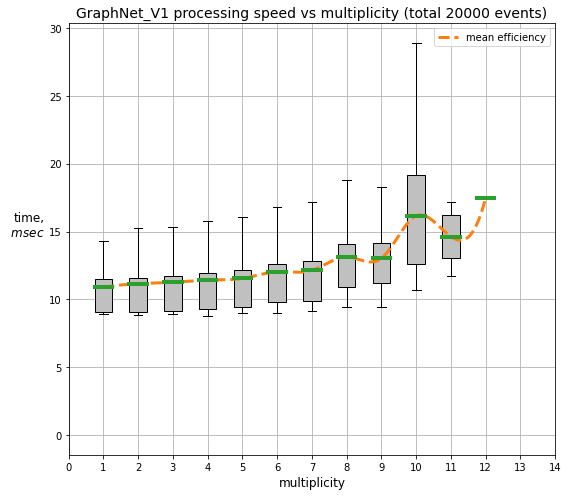

In [203]:
def get_diagram_arr_linspacer(all_real_hits, found_hits, start, end, num, col):
    spac = np.linspace(start, end, num=num)
    step = (spac[1] - spac[0]) / 2
    arr = []
    spac_ret = []
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] >= beg) & (all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] >= beg) & (found_hits[col] < end)]
        #print(beg,end)
        #print(len(elems_pred), len(elems_real))
        if elems_real.empty:
        #    print("emp", beg, end)
            continue
        arr.append(elems_real.time.values * 1e-3)
        spac_ret.append(spac[i] + step)
    
    return np.array(arr), np.array(spac_ret)

def get_diagram_for_boxplot_ex(all_real_hits, found_hits, start, end, num, col, bin_array, int_mode):
    y_vals, x_vals = get_diagram_arr_linspacer(all_real_hits, found_hits, start, end, num, col)

    np_y_vals = np.array(y_vals)
    bin_array = bin_array

    
    res_x_array = []
    res_box_data = []
    mean_box_array = []
    
    for i in range(len(bin_array)-1):
        beg = bin_array[i]
        end = bin_array[i+1]
        y_ind = np.where((x_vals>=beg) & (x_vals<end))
        y_vals_corr  = np_y_vals[y_ind]
        if len(y_vals_corr) == 0:
             continue
        y_vals_corr = np.concatenate(y_vals_corr, axis=-1)
        y_vals_corr = y_vals_corr[~np.isnan(y_vals_corr)]
        if len(y_vals_corr) == 0:
             continue
                
        #print(beg, end, i, stats.describe(y_vals_corr))
        #print(y_vals_corr)
#         if len(np.where(y_vals_corr < 1)) > 0:
#             print(y_vals_corr)
#             print(y_vals)
#             print(beg,end)
        
        res_box_data.append(y_vals_corr)
        delta = 0 if int_mode else (end-beg)/2
        res_x_array.append(beg + delta)
        mean_box_array.append(np.mean(y_vals_corr))

    return res_box_data, np.array(res_x_array), np.array(mean_box_array)

draw_for_col(events_real, events_pred_true, 'multiplicity', 'multiplicity',20000, 13, 
             custom_title='GraphNet_V1 processing speed vs multiplicity (total %d events)' % (20000),
             n_avg_ticks=11,x_ticks=13, int_mode=True, ticks_custom=False,
             custom_draw_funcs=[
                 lambda ax: 
                 ax.set_ylabel('time,\n $m sec$', fontsize=12,rotation=0, ha='right') #and
                 #ax.set_ylim((0,0.02))
             ],
             with_boxplot=True, diagram_func=get_diagram_for_boxplot_ex,color_ax_ticks=False)

